### Imports

In [13]:
import pandas as pd
import re 
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, HTML


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Functions

In [70]:
def get_wpm(df):
    """
    Get the average words per minute for the entire movie
    """
    seconds = df.tail(1).index.values[0]
    words = df.tail(1).values[0][0]
    
    return round(words/seconds*60,2)

In [5]:
def clean_text(line):
    """
    General string cleaning for these files
    Removes html tags, leading dashes, and all scenn descriptors ex: (MUSIC IN BACKGROUND)
    """
    clean = line.strip().replace('</i>', '').replace('<i>','').replace('- ', '')
    
    clean = re.sub('\(.*\)','', clean)
    clean = re.sub('\[.*\]','', clean)
    clean = re.sub('♪', '', clean)
    
    return(clean)

In [6]:
def is_time(line): 
    """
    Checks the current line to see if it's the time of the scene 
    """
    if re.match("[0-9][0-9]:", line):
        out = True
    else:
        out = False
        
    return out

In [66]:
def get_scene_end(line): 
    """
    Grab the end time of a frame's subtitles
    """
    line = line.strip()
    end = line.split(' --> ')[1]
    
    end_dt = datetime.strptime(end, '%H:%M:%S,%f')
    
    return(end_dt)

In [8]:
def count_words(line):
    """
    Count the number of words in a line
    """
    out = len(line.split(' '))
    return out

In [9]:
def parse_file(file_path):    
    """
    Main function for parsing a file it works as follow: 
        1. Open the file and read each line 
        2. Clean each line as you go 
        3. If it's just a subtitle number skip it
        4. If it's a timestamp, grab the end time of the scene
        5. If it's text, count the number of words 
    """
    
    base_time = datetime(1900, 1, 1, 0, 0, 0, 0)
    total_time = 0
    total_words = 0 
    dict_list = []


    with open(file_path, "r") as file: 
        # Read in all the lines
        lines = file.readlines()

        # Skip the first line with the weird /ueff stuff
        lines = lines[1:]

        # Start the loop 
        for line in lines: 
            line = clean_text(line)

            if line and (not line.isnumeric()): # skips the blank and line number
                if is_time(line):
                    total_time = (get_scene_end(line) - base_time).seconds
                else:
                    total_words += count_words(line)

            d = {
                'seconds': total_time, 
                'word_count': total_words
            }

            dict_list.append(d)        


    # Create fivethirtyeight dataframe
    script_df = pd.DataFrame(dict_list)
    script_df = pd.DataFrame(script_df.groupby(['seconds'])['word_count'].max())

    return script_df

### Parsing

In [24]:
humcc = parse_file("hum.srt") 
autocc = parse_file("auto.srt") 

# Readibility

### Word and character count over time

Text(0.5, 1.0, 'Video Word Count over Time')

Text(0.5, 0, 'Seconds')

Text(0, 0.5, 'Word Count')

(-30.0, 599.3)

(-50.0, 1592.85)

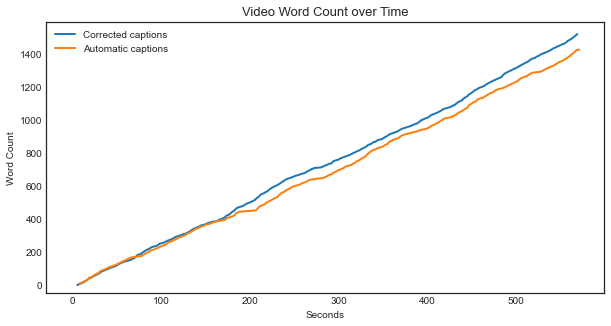

In [65]:
plt.style.use('seaborn-white')

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
width = 2

ax.plot(humcc.word_count, linewidth=width)
ax.plot(autocc.word_count, linewidth=width)

ax.set_title('Video Word Count over Time', fontsize=13)
ax.set_xlabel('Seconds', fontsize = 10)
ax.set_ylabel('Word Count', fontsize = 10)

ax.set_xlim(-30)
ax.set_ylim(-50)

ax.legend(labels = ['Corrected captions', 
            'Automatic captions', 
            ]
         )

plt.show()
fig.savefig('total_view.png')

## WPM and CPS

In [82]:
humcc_wpm =  get_wpm(humcc)
autocc_wpm =  get_wpm(autocc)

humcc_cps = int(humcc_wpm * 5.0 / 60.00)
autocc_cps = int(autocc_wpm * 5.0 / 60.0)

In [83]:
print("Corrected captions display {} wpm and {} cps".format(humcc_wpm, humcc_cps))
print("Automatic captions display {} wpm and {} cps".format(autocc_wpm, autocc_cps))

Corrected captions display 159.96 wpm and 13
Automatic captions display 149.53 wpm and 12


### WPM Plot

In [86]:
vector = [humcc_wpm,autocc_wpm]

names = ['Corrected captions',
        'Automatic captions']

y_pos = np.arange(len(vector))

<Figure size 360x360 with 0 Axes>

([<matplotlib.axis.XTick at 0x7fe92e5a9910>,
 [Text(0, 0, 'Corrected captions'), Text(1, 0, 'Automatic captions')])

Text(0.5, 1.0, 'Average words per minute')

Text(0.5, 0, 'Caption type')

Text(0, 0.5, 'Words per minute')

(0.5, 167.958)

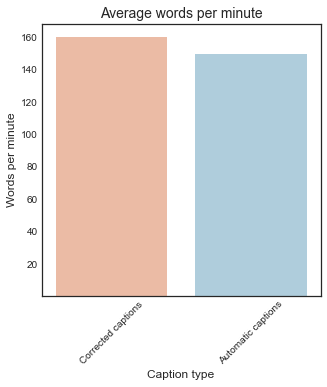

In [96]:
plt.figure(figsize=(5, 5))

chart = sns.barplot(x=names, y=vector, palette='RdBu')

plt.xticks(y_pos, names, rotation=45)
plt.title('Average words per minute', fontsize=14)
plt.xlabel('Caption type', fontsize=12)
plt.ylabel('Words per minute', fontsize=12)
plt.ylim(.5)
plt.show()

fig = chart.get_figure()
fig.savefig('average_wpm.png')

### CPS Plot

In [98]:
vector = [humcc_cps,autocc_cps]

names = ['Corrected captions',
        'Automatic captions']

y_pos = np.arange(len(vector))

<Figure size 360x360 with 0 Axes>

([<matplotlib.axis.XTick at 0x7fe92ebfd7c0>,
 [Text(0, 0, 'Corrected captions'), Text(1, 0, 'Automatic captions')])

Text(0.5, 1.0, 'Average characters per seconds')

Text(0.5, 0, 'Caption type')

Text(0, 0.5, 'Characters per Second')

(0.5, 13.65)

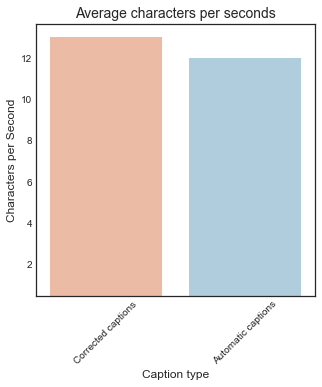

In [99]:
plt.figure(figsize=(5, 5))

chart = sns.barplot(x=names, y=vector, palette='RdBu')

plt.xticks(y_pos, names, rotation=45)
plt.title('Average characters per seconds', fontsize=14)
plt.xlabel('Caption type', fontsize=12)
plt.ylabel('Characters per Second', fontsize=12)
plt.ylim(.5)
plt.show()

fig = chart.get_figure()
fig.savefig('average_wps.png')

### References

Onofrey, E. (2019) Analyzing Movie Dialog Speed with Python. 

https://towardsdatascience.com/analyzing-movie-dialog-speed-with-python-79a8a8a286e8

https://github.com/eonofrey/movie_word_counts